## import

In [1]:
#importing libraries & packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

#display multiple outputs from cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sklearn

In [221]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, r2_score, classification_report

In [3]:
# import Animal Control Incidents df
df = pd.read_csv('Animal_Control_Incidents.csv')

#preserving original df before making alterations
raw_df = df.copy()

## functions

In [4]:
# regex for letters and '/' only, unless pattern reassigned
def remove_numpunc(list, pattern='[^A-Za-z,]+'):
    """regex to apply to list/df column --default: to include only letters and '/' """
    pattern = pattern
    #pattern = '[^A-Za-z_]+'
    if pattern =='[^A-Za-z,]+':
        list = [re.sub(pattern, ',', i) for i in list] 
    if pattern == '[^A-Za-z_]+':
        list = [re.sub(pattern, '', i) for i in list]
    if pattern == '[^A-Za-z/]+':
        list = [re.sub(pattern, '/', i) for i in list]
    if pattern == '[^0-9]+':
        list = [re.sub(pattern, '', i) for i in list]
    return list

In [5]:
# str type, eliminate misplaced whitespace, lower casing, replacing blankspace with '_'
def clean_str(col):
    
    df[col] = df[col].astype(str, skipna=True)
    df[col] = df[col].str.strip()
    df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
    df[col] = df[col].str.lower()

In [6]:
# plotting counts of timedate data 
def plot_dtcount(td_df, col, limitsy = None, limitsx= None, overlap = True, labels = None):
    """Plots incident count(y) with timeframe as x axis:
    
        td_df = dataframe with date/time
        col = date/time column(s) of dataframe to plot counts
        limitsy= (y,y), limitsx= (x,x) can be adjusted
         -, helful if wanting to exclude extreme outliers -
         overlap= boolean(if looping and want plots seperately plotted, set to False)
         labels= str or list of str for legend
         """
    
    td_df[col] = td_df[col].dropna()
    time_c = td_df.groupby([col])[col].count()
    
    if limitsy:
        plt.ylim(limitsy)
        
    if limitsx:
        plt.xlim(limitsx)

    if labels:
        plt.legend(
        (labels),
        loc='upper right'
        ,fontsize= 12)
    
    plt.scatter(time_c.index, time_c.values, s= 5, alpha=.3, label=col)
    if not overlap:
        plt.xlabel(col)
        plt.show();

In [7]:
# pretty blue/green seaborn correlation plot for categorical data
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    """pretty blue/green seaborn correlation plot:
    
    data= dataframe(will include all columns)
    minv = -float, maxv = float  --adjust closer to 0 for more contrast, closer to -1/1 for less
    dummy = False if df is all numerical. when True:function will only dummy categorical features
    """
    
    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

In [8]:
#sns countplot loop - probably unnecessary
def plot_counts(cols):
    for i, col in enumerate(cols):
       # print(df[col].value_counts())
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [9]:
# replacing strings and substrings FOR COLOR COLUMN ONLY(could be made more universal)
def edit_replace(old_words, replacement_word):
    """simple replacing strings or list in the df.color column since used so frequently in editting"""
    for word in old_words:
        df['color'] = df['color'].apply(lambda x: x.replace(word, replacement_word))

# __Cleaning__

### overview

looking at size, data types, 'na's

In [10]:
df.shape

(73303, 38)

In [11]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


In [12]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73303 entries, 0 to 73302
Data columns (total 38 columns):
file_number             73303 non-null int64
incident_date           73303 non-null object
incident_time           72818 non-null object
dispatched_time         62547 non-null object
call_taker              53134 non-null object
dispatcher              60239 non-null object
dispatched_other        73303 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62545 non-null object
complainant_street      73281 non-null object
request_type            40141 non-null object
officer                 61235 non-null object
equipment_number        60251 non-null object
remarks                 2098 non-null object
impound_number          53110 non-null float64
impound_date            53105 non-null object
impound_time            53046 non-null object
location                52867 non-null object
municipality       

Although most features are classified appropriately, some of these columns would be better described as object than int or float. There are also many dates and times to convert to datetime.

In [14]:
# # float and int columns with no numerical value
# obj_cols = ('dispatched_other', 'impound_number', 'zip_code', 'color', 'breed')

# # converting to object
# for col in obj_cols:
#     df[col] = df[col].astype(str)

Checking for duplicates:

In [15]:
# any duplicate rows?
print (len(df[df.duplicated(keep=False)])/len(df))
df[df.duplicated(keep=False)]

0.005170320450731894


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
36519,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36520,2012224989,01/17/2012,8:16,8:49,BC,BC,0,D,9:11,9:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRANS CAA,01/17/2012,NaN
36738,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36739,2012228091,03/16/2012,10:34,13:10,NaN,BC,0,D,13:22,13:30,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,03/16/2012,SW1
36862,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36863,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36864,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
36865,2012231293,05/15/2012,8:32,9:27,NaN,BC,0,D,9:36,9:45,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,05/15/2012,SW1
37062,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1
37063,2012226886,02/22/2012,17:4,NaN,TR,NaN,0,NaN,NaN,NaN,...,FAIR,NORMAL,NaN,NaN,NaN,NaN,NaN,TRANS CAA,02/22/2012,SW1


In [16]:
# removing duplicate rows from df - likely data entry mistakes
df.drop_duplicates(keep=False, inplace=True)

File numbers should all be unique to each incident. Repeated file numbers could be duplicates of the same incident with benign differences/errors.

In [17]:
# duplicate file numbers could also indicate duplicates with minor indiscretions 
print (len(df[df.duplicated(subset=['file_number','incident_date'], keep=False)])/len(df))
df[df.duplicated(subset=['file_number'], keep=False)]

0.19401020240250125


,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,dispatched_other,dispatched_situation,arrival_time,available_time,...,condition,temperment,collar,collar_color,vaccination_number,vaccination_date,pet_name,disposition,disposition_date,disposition_officer
11,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
16,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
25,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
36,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
69,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
72,201639000,12/27/2016,09:59,10:00,UNKNOWN,JENNIFER G,0,D,10:06,10:15,...,GOOD,FRIENDLY,SPIKE,SILVER,NaN,NaN,NaN,TRANS CAA,12/27/2016,JOHN B
95,201630574,06/01/2016,13:59,00:00,UNKNOWN,JENNIFER G,0,K,00:00,00:00,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,NaN,SEDWIN B
100,201639000,12/27/2016,09:59,10:00,UNKNOWN,JENNIFER G,0,D,10:06,10:15,...,FAIR,FRIENDLY,SPIKE,SILVER,NaN,NaN,NaN,TRANS CAA,12/27/2016,JOHN B
128,201639121,12/30/2016,08:42,09:28,UNKNOWN,JENNIFER G,0,D,09:36,09:47,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/30/2016,LW
135,201639122,12/30/2016,10:15,10:35,UNKNOWN,JENNIFER G,0,D,10:40,10:50,...,EMACIATED,NERVOUS,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/30/2016,JASON C


I'll use the code below after some columns have been trimmed from df so the more important features will be considered when the rows with the least nas are chosen

In [18]:
# # this should drop duplicate file number rows, keeping the row with the lease nas
# df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]

How much nas per column are there?

In [19]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number               0.0
incident_date             0.0
incident_time             1.0
dispatched_time          14.0
call_taker               27.0
dispatcher               18.0
dispatched_other          0.0
dispatched_situation     14.0
arrival_time             15.0
available_time           14.0
complainant_street        0.0
request_type             45.0
officer                  17.0
equipment_number         18.0
remarks                  97.0
impound_number           28.0
impound_date             28.0
impound_time             28.0
location                 28.0
municipality             28.0
zip_code                 67.0
service_code             28.0
species                  28.0
breed                    29.0
sex                      45.0
size                     29.0
color                    30.0
age                      55.0
condition                31.0
temperment               30.0
collar                   66.0
collar_color             66.0
vaccination_number       99.0
vaccinatio

Since most features are missing substantial amounts of data, I want to be careful about dropping nas to avoid tossing out useful information with the nulls.

In [20]:
# removing columns with 90%+ missing:
df.drop(columns=['remarks', 'vaccination_number', 'vaccination_date', 'collar', 'collar_color', 'pet_name']
        , inplace=True)

In [21]:
#removing row with nas from incident time since such little nas(1% rows)
df = df[df['incident_time'].notna()]

In [22]:
# preserve df 
df1 = df.copy()

In [23]:
#df=df1

### date & time

Converting dates and times to appropriate format.


- Merging incident date and time to datetime column, repeat with impound date & time.

In [24]:
# incident date + incident time for merged datetime column
df['inc_dt'] = pd.to_datetime(df['incident_date'].apply(str)+' '+df['incident_time'])

In [25]:
# impound date + impound time = impound datetime
df['imp_dt'] = pd.to_datetime(df['impound_date'].apply(str)+' '+df['impound_time'], errors ='coerce')

___
__Time Features:__

In [26]:
# time columns to list, then loop conversion to date.time
time_cols= [col for col in df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [27]:
print('Incident time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

Incident time Range:
from 00:04:00 
 to: 23:58:00


___
__Date Features:__

In [28]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

# covert to month/day/year datetime format
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y").dt.date

In [29]:
# date range of dataset
print('Incident Date Range:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

Incident Date Range:
from: 2012-01-01 
 to: 2019-10-03


In [30]:
df = df[(df['inc_dt'] > '2012-01-01')]

#### additional time features:

___
Below, I will be:


- Creating feature representing time difference between incident time and impound time.  

*_The incident date&time is when the incident was called in, the impound time is when the animal was brought to the shelter. It's possible that not every incident called in resulted in an impound, which may be the reason values are missing from impound._


__difference between datetime of incident call and impound datetime__

In [31]:
# time difference from incident to impound
df['inc_to_imp'] = df['imp_dt']-df['inc_dt']

___
Weekday and Month:

This may not provide anything insightful, but I'm creating columns for weekday and month of incident.

__- Weekday Feature-__

In [32]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['incident_date']).apply(lambda x: x.weekday())

df.weekday.value_counts()
# 0= monday

0    15960
1    14032
2    13513
3    13072
4    11984
5     2149
6     1740
Name: weekday, dtype: int64

It looks like most incidents occur on Mondays, and then dwindle down throughout the week, with much less incidents reported on weekends

Are the amount of impounds per day relative to the amount of incidents?

In [33]:
# how does incident day of week compare to impound day of week?:
imp_weekday_counts=(pd.to_datetime(df['impound_date'].dropna()).apply(lambda x: x.weekday()).value_counts())
(imp_weekday_counts.sum())/(df.weekday.value_counts().sum())
imp_weekday_counts/df.weekday.value_counts()
# 0= monday

0.7212146307798482

0    0.628195
1    0.676026
2    0.704729
3    0.707925
4    0.726469
5    1.359702
6    1.341954
dtype: float64

Something seems strange here. The dataframe has 76% of total not-null impounds to total incidents, why would there be 30% more impounds than incidents on any of the days, especially weekends?

___
__- Month feature-__

In [34]:
# column for month
df['month'] = pd.DatetimeIndex(df['incident_date']).month

df.month.value_counts()

5     7869
8     6906
6     6894
7     6663
9     6445
10    6385
4     5953
3     5632
1     5371
2     5051
11    4785
12    4496
Name: month, dtype: int64

__Warmer Climate = More Animal Control Incidents?__

May-September appear to have the most incidents. According to weather.com, the average temperature increases rises from the 50's to 60's degree Fahrenheit around min April, and then begins to dip below the 60s again towards the end of October(although Baton Rouge typically experiences the most volume in rainfall in June and August). Using that information, you can infer a positive correlation between weather and incidents, similar to the common correlation with temperature and crime.

*_Note that since the dates run between Jan-1-2012 to Oct-3rd-2019, there will be bias towards the first 10 months._

### animal features

Animals features include __color__, __breed__, __condition__, __temperment__, and __size__. color and breed present an issue with such high unique values for what should be considered , multiple spellings for the same color/breed, and alternate sequences of the same substrings appearing as different values( i.e. brown/white vs white/brown)

#### color

##### unifying spellings of colors

In [35]:
#df.color.value_counts()
df.color.value_counts()

BLK                          4026
BLK/WHT                      3973
GRY                          3201
BRWN/WHT                     1592
GRY/WHT                      1565
TAN/WHT                      1470
BRWN                         1418
TAN                          1417
BLK/TAN                      1295
GRAY                         1084
BROWN                        1053
GREY                          928
GRY/BLK                       915
WHT                           903
BLK/GRY                       789
BLK/BRWN                      762
BRWN/BLK                      754
WHT/BLK                       752
ORG                           716
BLACK                         716
WHT/BRWN                      633
BRN/BLK                       615
BRINDLE                       588
BRN                           521
WHT/TAN                       511
TAN/BLK                       508
WHITE                         388
WHT/GRY                       386
NORMAL                        379
YELLOW        

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [36]:
pre_color = df.copy()

In [37]:
df= pre_color.copy()

In [38]:
clean_str('color')

In [39]:
df['color'] = remove_numpunc(df.color, pattern = '[^A-Za-z,]+')

By looking at value counts of strings, I can decide which ones need uniform spelling. The ones with higher counts will be prioritized, and some may slip through the cracks, as it is a tedious task. Colors with strong similarity will be placed into major color categories as well, at my discretion.(ie. tan, sandy, and blonde all identified as 'tan') 

##### editting color names

In [40]:
# white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie'
          , 'wwht', 'what','wt','whitge','whiite','whute','shite')

edit_replace(whites, 'wht')

In [41]:
# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack'
          , 'blavck', 'blkc', 'blakc')

edit_replace(blacks, 'bk')

In [42]:
# browns: br
browns = ('brown','brrwn', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate'
          , 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate'
          , 'brblk','chestnut', 'cho', 'brrwn', 'bbrown','bown')

edit_replace(browns,'br')

In [43]:
# greys: gry
greys = ('grey', 'gray', 'grrey','greymarble')

edit_replace(greys, 'gry')

In [44]:
# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

In [45]:
# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

In [46]:
# calico = cal
edit_replace(('calico','claico'), 'cal')

In [47]:
# orange: or
oranges = ('orange', 'orn', 'copper', 'orang', 'orage', 'ornage')

edit_replace(oranges, 'org')

In [48]:
# brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

In [49]:
# yellow: yel
edit_replace(('yellow','yelow','yellw', 'yell', 'ylw'), 'yel')

In [50]:
# stop words and not decribing color (* is there a better way to do this?)
to_drop = ('chest','and', 'normal', 'nose', 'paws', 'mouth', 'with', 'tail'
           , 'belly', 'head', 'ears', 'eyes', 'face', 'feet', 'color', 'standard',
          'fred', 'pattern', 'newbord', 'mostly', 'front', 'all', 'body', 'little', ' ', '  ')

edit_replace(to_drop, '')

In [51]:
# other and unknown in nan category
unknowns = ('unknown')

edit_replace(unknowns, 'other')

In [52]:
# replace empty values with other
df['color'] = df['color'].apply(lambda x: x.strip()).replace('', 'other')

##### alphabetizing and 'other' feature for low value counts

In [53]:
df['color'] = [','.join(sorted(i.split(','))) for i in df['color']]

In [54]:
df['color'] = df['color'].apply(lambda x : x[1:] if x.startswith(",") else x)

In [55]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

In [56]:
#df['color'] = df['color'].apply(lambda x: ','.join((x.split(',').sort())))

In [57]:
# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 10].index)]

other_color_df['color'] = 'other'

In [58]:
#should be one value: 'other'
other_color_df.color.value_counts()

other    1168
Name: color, dtype: int64

In [59]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 10].index)]

In [60]:
#should be n or more per value
colors_df.color.value_counts().tail()

botherther,otherh              10
botherther,otherht,spothert    10
blotherthere,gry,otherht       10
br,light                       10
gr,otherht                     10
Name: color, dtype: int64

In [61]:
#joining the 'other color' and 'all colors' dfs
ec_df = pd.concat([colors_df,other_color_df ])
len(ec_df)

72450

In [62]:
#all should have a minimum n value counts, 'other' should now be included
df = ec_df.copy()
df.color.value_counts()

othertheraotherther                   21526
botherther,otherht                     5676
gry                                    5228
botherther                             4756
br,otherht                             3295
br                                     3118
botherther,gry                         2926
botherther,br                          2897
gry,otherht                            2879
otherht,totherther                     2655
botherther,totherther                  2306
totherther                             1700
other                                  1550
otherht                                1383
botherther,br,otherht                   984
bothertherdle                           839
otherrg                                 827
botherther,otherht,totherther           706
bothertherdle,otherht                   595
br,gry                                  592
gry,totherther                          558
otherht,otherrg                         497
botherther,gry,otherht          

#### breed

In [63]:
pre_breed = pre_color.copy()

In [64]:
df= pre_breed

In [65]:
df.breed.value_counts()

DSH                               11440
POSSUM                             5411
PITBULL                            5363
RACCOON                            4345
XPIT BULL                          4232
XLABRADOR                          2807
XTERRIER                           1372
XSHEPHERD                           938
PIT                                 922
LABRADOR RETRIEVER                  911
DMH                                 827
GERMAN SHEPHERD                     780
TERRIER                             763
DLH                                 711
XGERMAN SHEPHERD                    614
XHOUND                              541
CHIHUAHUA                           447
SQUIRREL                            400
XCHIHUAHUA                          374
HORSE                               351
OTHER                               329
SHIH TZU                            313
XROTTWEILER                         303
ROTTWEILLER                         294
ARMADILLO                           285


 *_DSH=Domestic Short Hair, DMH= Domestic Medium Hair, and DLH=Domestic Long Hair_

In [66]:
df['breed'] = df['breed'].apply(lambda x : x[1:] if str(x).startswith("X") else x)

In [67]:
clean_str('breed')

In [68]:
df['breed'] = df.breed.apply(lambda x: x.replace('__', '_'))

df['breed'] = remove_numpunc(df['breed'], pattern='[^A-Za-z_]+')

*_some of these breeds sound very similar(ie. staffordshire bull terrier vs american staffordshire terrier, doberman vs doberman pinscher, but I have investigated the questionably similar breeds before reassigning to the same variable._

In [69]:
def rep_breed(word, replacement):
    df['breed'] = df['breed'].apply(lambda x: x.replace(word, replacement)) 

In [70]:
# replacing breed names 
rep_breed('chow_chow', 'chow')
rep_breed('boston_terrier', 'boston')
rep_breed('poodle_standard', 'poodle')
rep_breed('basset_hound', 'basset')
rep_breed('rottweiller', 'rott')
rep_breed('rottweiler', 'rott')
rep_breed('pit_bull', 'pitbull')
rep_breed('pitbull', 'pit')
rep_breed('labrador_retriever', 'labrador')
rep_breed('catahoula_hound', 'catahoula')
rep_breed('english_bulldog', 'bulldog_english')
rep_breed('shar_pei', 'sharpei')
rep_breed('brittany_spaniel', 'brittany')
rep_breed('other', 'unknown')

In [71]:
#len(df.breed.value_counts())
df.breed.value_counts()

nan                               21001
dsh                               11440
pit                               10520
possum                             5411
raccoon                            4345
labrador                           3718
terrier                            2135
german_shepherd                    1548
shepherd                           1027
dmh                                 827
chihuahua                           821
dlh                                 711
hound                               663
rott                                597
boxer                               442
unknown                             416
squirrel                            400
horse                               351
beagle                              339
catahoula                           324
chow                                320
shih_tzu                            313
armadillo                           285
dachshund                           244
retriever                           239


#### condition, disposition, size, species, temperment

In [72]:
cdsst ='species', 'size', 'condition', 'temperment', 'disposition'

In [73]:
for col in cdsst:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')

In [74]:
for col in cdsst:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Species --
 dog          26381
nan          20215
cat          13179
wildlife     11079
livestock      464
reptile        409
fowl           335
bird           172
birds          129
unknown         43
other           38
exotic           6
Name: species, dtype: int64 

-- Size --
 medium         23143
nan            21452
large          15081
small          10738
extra_large     1235
unknown          801
Name: size, dtype: int64 

-- Condition --
 fair         34191
nan          22397
good          8432
emaciated     5835
unknown       1056
excellent      294
poor           245
Name: condition, dtype: int64 

-- Temperment --
 normal       24205
nan          21792
friendly     12989
nervous      11423
dangerous     1350
unknown        664
scared          27
Name: temperment, dtype: int64 

-- Disposition --
 trans_caa            39062
nan                  20200
return_to_wild        9790
return_to_owner       1989
special_caseother      985
euthanized             265
dead_on_arrival

### impound_number

In [114]:
df.impound_number.value_counts()

0.0        20
51401.0     2
56895.0     2
27535.0     2
52488.0     2
31838.0     2
42765.0     2
29797.0     2
36297.0     2
35637.0     2
53254.0     2
38486.0     2
26836.0     2
38496.0     2
59335.0     2
22659.0     2
27288.0     2
22119.0     2
63752.0     2
26970.0     2
36360.0     2
62381.0     2
21059.0     2
25162.0     2
40689.0     2
28289.0     2
59758.0     2
40362.0     2
23618.0     2
58743.0     2
           ..
23950.0     1
79167.0     1
45034.0     1
55089.0     1
22822.0     1
79166.0     1
58687.0     1
41142.0     1
79169.0     1
23373.0     1
35835.0     1
48477.0     1
47093.0     1
29889.0     1
57993.0     1
76064.0     1
79172.0     1
76071.0     1
42459.0     1
46757.0     1
21095.0     1
90065.0     1
79171.0     1
79071.0     1
59834.0     1
87682.0     1
28260.0     1
79170.0     1
50134.0     1
90112.0     1
Name: impound_number, Length: 43226, dtype: int64

#### age, sex, 

these features are both missing roughly 50%

In [75]:
df.age.value_counts()/df.age.value_counts().sum()

0.0     0.995674
2.0     0.000834
3.0     0.000649
5.0     0.000618
4.0     0.000371
1.0     0.000309
6.0     0.000216
7.0     0.000216
10.0    0.000216
9.0     0.000185
8.0     0.000185
13.0    0.000124
12.0    0.000124
15.0    0.000062
16.0    0.000062
11.0    0.000062
14.0    0.000062
17.0    0.000031
Name: age, dtype: float64

I'm having a hard time believing that 99% of the animals were 0 years old. I will be excluding this column. 

In [76]:
df.drop(columns=['age'], inplace=True)

In [77]:
df.sex.value_counts()/df.sex.value_counts().sum()

M    0.352732
U    0.332752
F    0.314267
1    0.000075
K    0.000050
D    0.000050
N    0.000025
0    0.000025
S    0.000025
Name: sex, dtype: float64

In [78]:
df.drop(columns=['sex'], inplace=True)

### service code, request type (service_type)

In [79]:
sr = ('service_code', 'request_type')

In [80]:
for col in sr:
    print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

-- Service_code --
 TRAPPED ANIMAL           17504
STRAY                     8152
STRAY AN. SECURED         4868
STRAY AN SECURED          3119
LOOSE                     2711
OWNER SIGNED RELEASE      2183
INJURED                   1975
ABANDONED ANIMAL          1883
WILD LIVE                 1295
CRUELTY                   1138
UNIT STANDING BY          1125
BITE CASE LOOSE            929
ANIMAL RESCUE              834
SICK ANIMAL                796
VET PICKUP                 715
DANGEROUS ANIMAL SIT.      462
BITE CASE SECURE           450
DANGEROUS ANIMAL SIT       374
SNAKE                      337
LOOSE LIVESTOCK            329
SPECIAL CASE               307
UNKNOWN                    260
SCHOOL CALL                258
DOG FIGHTING               131
BITE CASE                  117
OWNED                        4
HIT BY CAR                   1
Name: service_code, dtype: int64 

-- Request_type --
 UNKNOWN                       6822
TRAPPED ANIMAL                6199
STRAY             

In [81]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

# dropping merged columns
df.drop(columns=['service_code', 'request_type'], inplace=True)

In [82]:
# removing punctuations, lower casing, etc..
clean_str('service_type')
df['service_type'] = remove_numpunc(df['service_type'], pattern='[^A-Za-z_]+')

In [83]:
def rep_service(word, replacement):
    df['service_type'] = df['service_type'].apply(lambda x: x.replace(word, replacement))  

In [84]:
# unifying service types

# dangerous animal situation
rep_service('dangerous_animal_situation', 'dangerous_animal_sit')

# cruelty cases
rep_service('cruelty_case', 'cruelty')

# stray animals
rep_service('stray_animal_secured', 'stray_an_secured')

#loose animal and loose could include loose livestock, so I will assign all to 'loose'
rep_service('loose_live_stock', 'loose_livestock')
rep_service('loose_livestock', 'loose')
rep_service('loose_animal', 'loose')

# injured - injured animal and injured dog all under injured
rep_service('injured_animal', 'injured')
rep_service('injured_dog', 'injured')
rep_service('hit_by_car', 'injured')

#
rep_service('delivered_tags', 'deliver_tags')

rep_service('wild_live', 'wild_life')

rep_service('other', 'unknown')

rep_service('abandoned_dog', 'abandoned_animal')
rep_service('abandoned_animal', 'abandoned')

rep_service('animal_on_school_campus', 'school_call')

rep_service('owned', 'owner_signed_release')

In [85]:
df.service_type.value_counts()

trapped_animal                17894
stray                         10229
stray_an_secured               8368
unknown                        5932
loose                          4760
cruelty                        2577
injured                        2336
abandoned                      2312
owner_signed_release           2268
wild_life                      1585
animal_rescue                  1333
unit_standing_by               1333
dangerous_animal_sit           1165
deliver_tags                   1073
bite_case_loose                 929
sick_animal                     879
vet_pickup                      793
pick_up_trap                    784
bite_case                       771
special_case                    680
snake                           675
patrol_area                     654
pit                             618
cruelty_recheck                 509
deliver_trap                    479
bite_case_secure                450
school_call                     349
pick_up_or_deliver_package  

### equipment number

ID of the vehicle sent to the incident location

In [86]:
df.equipment_number.value_counts()

AC04     6331
AC12     6075
AC09     6038
AC13     5547
AC10     4864
AC06     4773
AC11     4596
AC19     4410
AC01     3758
AC18     3713
AC16     3483
AC15     2818
AC14     1646
AC20      229
19        130
12        116
15         87
AC9        83
11         79
4          79
AC6        76
14         69
10         69
13         65
09         58
AC4        54
9          47
AC05       44
1          42
AC1        42
         ... 
06         17
AC 10      16
AC 4       15
04         14
AC 1       12
AC 9       10
AC08       10
AC 6        8
AC 18       7
AC 13       6
AC 8        6
AC 14       4
18          4
AC-14       3
AC 20       3
AC 12       3
17          3
5           3
AC5         2
AC-4        2
AC- 4       1
AC 15       1
AC 7        1
AC016       1
SC          1
ZAC14       1
AC198       1
AC-10       1
2692        1
4C18        1
Name: equipment_number, Length: 67, dtype: int64

In [87]:
clean_str('equipment_number')

In [88]:
df['equipment_number'] = remove_numpunc(df['equipment_number'], pattern ='[^0-9]+')

In [89]:
df['equipment_number'] = df['equipment_number'].apply(lambda x : x[1:] if x.startswith("0") else x)

In [90]:
df['equipment_number'] = df.equipment_number.replace('2692', 'nan')
df['equipment_number'] = df.equipment_number.replace('198', 'nan')
df['equipment_number'] = df.equipment_number.replace('418', 'nan')
df['equipment_number'] = df['equipment_number'].apply(lambda x : x.replace(x,'nan') if x=='' else x)

In [91]:
df.equipment_number.value_counts()

nan    12669
4       6496
9       6236
12      6194
13      5618
10      4950
6       4912
11      4698
19      4558
1       3878
18      3724
16      3525
15      2906
14      1723
20       232
5         49
7         35
17        31
8         16
Name: equipment_number, dtype: int64

### dispatched situation, dispatched other

- __dispatched situation:__ Indicates if officer was dispatched (D) or the call had to be postponed (K) and addressed the following day. ( _data source does not explain U,F, or N_ )


- __dispatched_other:__ Not dispatched by cad but there is dispatch info in record



In [92]:
for col in ('dispatched_situation', 'dispatched_other'):
    df[col].value_counts()

D    57385
K     4840
U      166
F        9
N        1
Name: dispatched_situation, dtype: int64

0    71082
1     1368
Name: dispatched_other, dtype: int64

In [93]:
# won't be needing these
df.drop(columns=['dispatched_situation', 'dispatched_other'], inplace=True)

### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [94]:
loc_cols = ('municipality', 'location', 'zip_code', 'complainant_street')

In [95]:
for col in loc_cols:
    df[col].value_counts()

BATON ROUGE    47367
PARISH          1699
ZACHARY         1186
BAKER            987
CENTRAL          772
UNKNOWN          242
Name: municipality, dtype: int64

2680 PROGRESS                  291
9465 GOODWOOD                  190
191 LSU                        145
19700 OLD SCENIC               125
16044 TIGER BEND                98
1071 CRESCENT                   85
21745 SAMUELS                   72
3803 SHERWOOD FOREST            70
6010 HUCKLEBERRY                60
16352 OLD HAMMOND               57
1657 BROCADE                    56
14867 PRIDE PORT HUDSON         55
2883 SARATOGA                   51
5922 GLEN COVE                  48
15545 OLD HAMMOND               48
3445 OZARK                      45
1126 SUNSHINE                   45
3579 VICTORIA                   45
36969 GSP                       44
1451 GREAT OAK                  44
845 WORDSWORTH                  43
3511 MYRTLE GROVE               42
7489 OAKMOUNT                   41
18733 SAMUELS                   41
6061 PLANK                      40
229 FLONACHER                   40
3144 SENECA                     40
8819 DYER                       38
13542 BROAD         

70805.0    3184
70816.0    1916
70802.0    1909
70815.0    1888
70791.0    1701
70807.0    1645
70810.0    1620
70714.0    1357
70806.0    1237
70808.0    1103
70811.0    1000
70817.0     975
70814.0     805
70812.0     720
70809.0     704
70739.0     506
70818.0     504
70820.0     356
70819.0     308
70770.0     247
70803.0     158
70777.0      76
70801.0      19
70722.0      11
70813.0       9
70836.0       9
70719.0       8
70804.0       4
70748.0       4
70726.0       3
           ... 
70822.0       3
70779.0       2
70711.0       2
70780.0       2
70891.0       2
70715.0       2
70441.0       1
70181.0       1
70708.0       1
70517.0       1
70707.0       1
70581.0       1
70700.0       1
70712.0       1
70716.0       1
70071.0       1
56864.0       1
70717.0       1
70718.0       1
70720.0       1
70741.0       1
70781.0       1
78014.0       1
70826.0       1
70905.0       1
70916.0       1
71810.0       1
77551.0       1
78006.0       1
57709.0       1
Name: zip_code, Length: 

GREENWELL SPRINGS RD    662
AIRLINE HW              651
PLANK RD                518
FLORIDA BL              516
JEFFERSON HW            496
LSU PL                  386
PERKINS RD              374
PROGRESS RD             324
GOODWOOD BL             320
OLD HAMMOND HW          302
HIGHLAND RD             281
PRESCOTT RD             276
OLD SCENIC HW           267
SCENIC HW               254
HARRELL'S FERRY RD      244
SHERWOOD FOREST BL      241
TIGER BEND RD           234
VICTORIA DR             223
MAIN ST                 193
HOOPER RD               183
SHERWOOD ST             175
O'NEAL LN               170
BLACKWATER RD           169
EVANGELINE ST           166
BYRON ST                160
FLONACHER RD            159
SIEGEN LN               155
FLANNERY RD             155
FAIRFIELDS AV           154
SHERWOOD FOREST DR      153
                       ... 
73RD AVE.                 1
VICTORIA  LOT# 84         1
STERN                     1
HIGH PINES                1
HAVANA DR           

interesting that there are so many incidents occurring at some of these unique addresses

In [96]:
df[df['location'] == '2680 PROGRESS']

,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,arrival_time,available_time,complainant_street,officer,...,temperment,disposition,disposition_date,disposition_officer,inc_dt,imp_dt,inc_to_imp,weekday,month,service_type
11,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
16,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
25,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
36,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
69,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
95,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
959,201739514,2017-01-11,12:43:00,00:00:00,JENNIFER G,UNKNOWN,00:00:00,00:00:00,PROGRESS RD,UNKNOWN,...,normal,trans_caa,2017-01-17,JASON C,2017-01-11 12:43:00,2017-01-17 08:00:00,5 days 19:17:00,2,1,abandoned
1247,201739945,2017-01-24,08:20:00,08:22:00,JOHN B,JENNIFER G,08:22:00,08:28:00,PROGRESS RD,JOHN B,...,normal,trans_caa,NaT,JOHN B,2017-01-24 08:20:00,2017-01-24 08:11:00,-1 days +23:51:00,1,1,abandoned
1266,201630073,2016-05-19,12:47:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,UNKNOWN,...,normal,trans_caa,NaT,ANNA C,2016-05-19 12:47:00,2016-05-09 22:19:00,-10 days +09:32:00,3,5,trapped_animal
1277,201739961,2017-01-24,10:50:00,10:51:00,UNKNOWN,JENNIFER G,10:51:00,10:51:00,PROGRESS RD,SUSAN W,...,normal,trans_caa,NaT,SUSAN W,2017-01-24 10:50:00,2016-12-22 09:44:00,-34 days +22:54:00,1,1,bite_case_secure


In [97]:
df.isna().sum()/len(df) *100

file_number             0.000000
incident_date           0.000000
incident_time           0.000000
dispatched_time        13.857833
call_taker             27.236715
dispatcher             17.152519
arrival_time           14.828157
available_time         13.860594
complainant_street      0.013803
officer                16.589372
equipment_number        0.000000
impound_number         27.871636
impound_date           27.878537
impound_time           28.876467
location               28.197378
municipality           27.877157
zip_code               66.825397
species                 0.000000
breed                   0.000000
size                    0.000000
color                  29.711525
condition               0.000000
temperment              0.000000
disposition             0.000000
disposition_date       47.904762
disposition_officer    28.924776
inc_dt                  0.000000
imp_dt                 28.881988
inc_to_imp             28.881988
weekday                 0.000000
month     

these all look different, but still wondering if I've missed some duplicates. after editing, some spelling and/or grammatical mistakes may have resulted in revealing more duplicates

In [98]:
# # how many addresses/ incident count
# df_loc = df[['incident_date', 'location']].dropna().reset_index()
# print (df_loc.groupby('incident_date')['location'].nunique().value_counts())

In [99]:
df[df.duplicated(['location', 'inc_dt', 'color', 'breed', 'species'], keep=False)]

,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,arrival_time,available_time,complainant_street,officer,...,temperment,disposition,disposition_date,disposition_officer,inc_dt,imp_dt,inc_to_imp,weekday,month,service_type
36,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
60,201638988,2016-12-27,09:14:00,09:14:00,JENNIFER G,JENNIFER G,09:14:00,09:14:00,CLERMONT ST,JW,...,nan,nan,NaT,NaN,2016-12-27 09:14:00,NaT,NaT,1,12,unknown
95,201630574,2016-06-01,13:59:00,00:00:00,UNKNOWN,JENNIFER G,00:00:00,00:00:00,PROGRESS RD,SEDWIN B,...,normal,trans_caa,NaT,SEDWIN B,2016-06-01 13:59:00,2016-06-26 08:45:00,24 days 18:46:00,2,6,owner_signed_release
112,201639112,2016-12-30,09:08:00,09:09:00,JENNIFER G,JENNIFER G,09:09:00,09:09:00,CASA LOMA DR,JASON C,...,nan,nan,NaT,NaN,2016-12-30 09:08:00,NaT,NaT,4,12,unknown
131,201639132,2016-12-30,09:08:00,09:12:00,UNKNOWN,JENNIFER G,09:25:00,09:28:00,EAST DR,LW,...,nan,nan,NaT,NaN,2016-12-30 09:08:00,NaT,NaT,4,12,unknown
174,201739165,2017-01-03,08:57:00,08:57:00,JENNIFER G,JENNIFER G,08:57:00,08:57:00,CHARLES ST,UNKNOWN,...,nan,nan,NaT,NaN,2017-01-03 08:57:00,NaT,NaT,1,1,unknown
176,201639108,2016-12-29,09:14:00,09:15:00,JENNIFER G,JENNIFER G,09:15:00,09:15:00,LAKE CT,SUE H,...,friendly,return_to_owner,2016-12-29,SUE H,2016-12-29 09:14:00,2016-12-28 19:51:00,-1 days +10:37:00,3,12,loose
177,201739197,2017-01-03,10:54:00,10:54:00,JENNIFER G,JENNIFER G,10:54:00,10:54:00,GIBBENS PAYNE AV,UNKNOWN,...,nan,nan,NaT,NaN,2017-01-03 10:54:00,NaT,NaT,1,1,unknown
189,201739201,2017-01-03,11:01:00,11:01:00,JENNIFER G,JENNIFER G,11:01:00,11:01:00,CHICKAMAUGA AV,UNKNOWN,...,nan,nan,NaT,NaN,2017-01-03 11:01:00,NaT,NaT,1,1,unknown
198,201739166,2017-01-03,08:57:00,08:58:00,JENNIFER G,JENNIFER G,08:58:00,08:58:00,ASTORIA DR,UNKNOWN,...,nan,nan,NaT,NaN,2017-01-03 08:57:00,NaT,NaT,1,1,unknown


In [100]:
for col in df[['municipality', 'location']]:
    clean_str(col)

In [101]:
clean_str('zip_code')
df['zip_code'] = remove_numpunc(df['zip_code'],pattern='[^0-9]+')

complainant street has no nas, but not sure if it provides value to analysis without a region

### names

In [102]:
name_cols = ['call_taker', 'dispatcher', 'officer', 'disposition_officer'] 

In [103]:

for col in name_cols:
    clean_str(col)
    df[col] = remove_numpunc(df[col], pattern='[^A-Za-z_]+')        

In [104]:
for col in name_cols:
    df[col].value_counts()

unknown       31029
nan           19733
jennifer_g     6467
bc             2889
john_b         1186
bg             1117
tr             1070
is              949
jb              817
jc              809
daniel_p        760
tz              746
jtg             640
sb              607
jg              573
tp              508
rt              470
sedwin_b        435
law             273
fs              232
ms              208
wb              183
dp              130
richard_b       112
ac               90
rosemary_a       62
sr               55
lw               55
sh               53
joey_g           40
ic               33
sw               21
jason_c          17
jpb              13
                  8
sue_h             7
isaac_s           6
frank_s           5
jw                5
anna_c            5
travis_r          5
mg                4
jeg               4
bjg               2
tf                2
jeb               2
bj                1
hc                1
tzz               1
ssw               1


jennifer_g    36692
bc            19709
nan           12427
unknown        1015
john_b          828
richard_b       777
sedwin_b        685
jtg             157
joey_g          143
bg                7
is                4
rt                2
tp                1
isaac_s           1
passpp            1
                  1
Name: dispatcher, dtype: int64

nan           12019
unknown        9558
frank_s        4781
anna_c         4174
travis_r       3579
tr             3564
jb             3284
jason_c        3261
john_b         3093
bg             2999
sue_h          2621
isaac_s        2295
sb             2161
sedwin_b       1978
lw             1394
is             1018
fs              917
jc              910
jtg             839
tz              802
allison_c       714
dd              657
jg              607
tp              570
jennifer_g      567
rt              516
mg              487
kd              388
jw              367
joey_g          333
              ...  
richard_b        46
hilton_c         31
sw               19
jpb              13
brent_g          11
                  9
bc                5
hc                5
jeg               4
kjg               4
susan_w           4
bjg               3
suzie_b           3
btg               2
kjc               2
fe                1
fr                1
djp               1
rrt               1


nan           20956
sw            19316
sb             4756
ph             3173
frank_s        2694
anna_c         2479
jl             2135
travis_r       2016
john_b         1841
jason_c        1693
lw             1552
allison_c      1501
sue_h          1461
sedwin_b       1305
isaac_s        1227
jtg            1001
dd              787
kd              525
djp             285
jw              241
joey_g          168
tim_z           158
tr              111
bg              104
jg               98
tp               94
rt               93
unknown          83
is               83
susan_w          75
              ...  
patty_h          41
kw               35
suzie_b          12
hilton_c          9
rosemary_a        7
ic                7
law               5
dp                3
jennifer_g        3
ab                2
bmg               2
jrl               2
richard_b         2
swi               2
jk                1
mg                1
iph               1
je                1
bjg               1


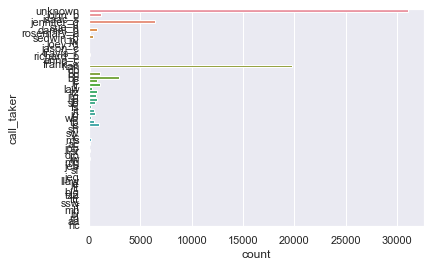

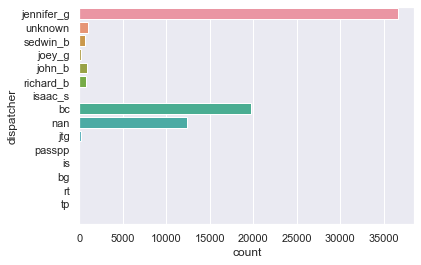

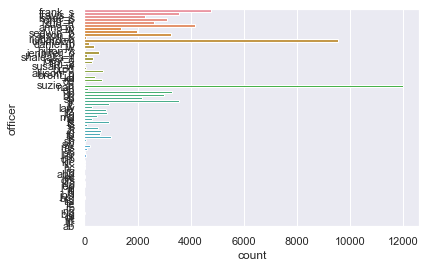

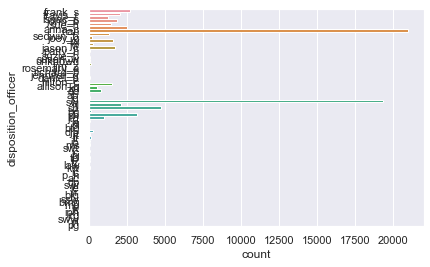

In [105]:
plot_counts(name_cols)

they're all very imbalanced, but dispatcher is the only one that doesn't look insanely messy.

If I was able to consult someone of knowledge at the baton rouge animal control facility, I would be able to sort out the names better(i.e. are any of the initials representative of the given full names, 

Below, I'm iterating through name columns to see how many days each unique name shows, and how many unique names show per day:  

Basically, 
- how many employees per position do they have on staff per day* &
-  how many days has that employee worked in that role(over the span of 6 years).*

*_(If we were to assume that daily, all workers had their names on at least one report in respective column)_

In [106]:
for col in name_cols:
# df with incident time and position dropping nas
    df2 = df[['incident_date', col]].dropna().reset_index()

# grouping df by unique count of worker in position per day
# then seeing how many days they have each given number of dispatchers
    print ('\nnumber of',col,'/ number of days\n',df2.groupby('incident_date')[col].nunique().value_counts())
# how many days does each employee position appear on indicent report
#    df3 = df[['incident_date', col]].dropna().reset_index()

#    print (' employee/ number of days worked')df3.groupby(col)['incident_date'].nunique())


number of call_taker / number of days
 3     723
2     616
4     515
5     239
1     198
6     105
7      63
8      22
9      11
10      5
11      2
Name: call_taker, dtype: int64

number of dispatcher / number of days
 1    1322
2    1163
3      13
4       1
Name: dispatcher, dtype: int64

number of officer / number of days
 7     390
6     357
5     339
8     303
4     289
3     264
9     160
2     154
10    106
1      69
11     45
12     19
13      4
Name: officer, dtype: int64

number of disposition_officer / number of days
 2     742
3     405
1     243
8     219
7     208
4     171
9     156
6     141
5      88
10     86
11     33
12      5
13      2
Name: disposition_officer, dtype: int64


if the above assumption were verified, it would appear:
- most often there are 1-3 call takers on staff, almost always between 1-5
- 1 dispatcher per day, very rarely 2 or 3, or could be data entry error
- usually 3-4, or between 1 and 7 officers
- usually 2 disposition officers, or between 1 and 4

In [107]:
#df.drop(columns = name_cols, inplace=True)

## dropping columns

In [126]:
# dropping duplicate file number rows, keeping the one with least nas
df = df.loc[df.notnull().sum(1).groupby(df.file_number).idxmax()]

In [127]:
# any other duplicates?
df[df.duplicated(subset=['impound_number', 'species', 'breed', 'service_type', 'incident_date'
                         , 'color', 'complainant_street', 'disposition', 'disposition_officer'
                        , 'location', 'complainant_street',  ], keep=False)]

,file_number,incident_date,incident_time,dispatched_time,call_taker,dispatcher,arrival_time,available_time,complainant_street,officer,...,temperment,disposition,disposition_date,disposition_officer,inc_dt,imp_dt,inc_to_imp,weekday,month,service_type


In [123]:
# sorting rows by number of nas per row descending
df = df.iloc[df.isnull().sum(axis=1).mul(-1).argsort()]

In [125]:
# once again drop duplicates, keeping row with least nas
df.drop_duplicates(subset=['impound_number', 'species', 'breed', 'service_type', 'incident_date', 'color'
                           , 'complainant_street', 'dispatched_time'], keep='last',inplace=True)

In [109]:
# # profile report
# pandas_profiling.ProfileReport(df)

# observations from pandas profile report:

# - lots of columns missing data

# unneeded columns:
# - ARRIVAL TIME- has most at 00:00
# - AVAILABLE TIME- most at 00:00
# - CALL TAKER
# - COLLAR
# - COLLAR COLOR
# - IMPOUND NUMBER
# - INCIDENT TIME
# - PET NAME
# - REMARKS(too little data provided(3%), existing data doesn't appear to be useful)
# - VACCINATION DATE(99.5% missing)
# - VACCINATION NUMBER
# - ZIP CODE


# columns needing work or consider exclusion:
# - AGE 55% missing
# - X in front of BREED- cross breed?
# - CONDITION 31% missing
# - DISPATCHED OTHER and DISPATCHED SITUATION- what does it mean?
# - EQUIPMENT NUMBER - what does it mean?
# - FILE NUMBER - probably not useful
# - REQUEST TYPE and SERVICE CODE appear to provide same content
# - SEX contains only 37% M or F, other data missing or irregular
# - SIZE 30% missing
# - SPECIES 28% missing
# - TEMPERMENT 30% missing
# - COLOR 29% missing
# - LOCATION and COMPLAINT STREET can be merged somehow?


In [128]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

file_number             0.0
incident_date           0.0
incident_time           0.0
dispatched_time        12.0
call_taker              0.0
dispatcher              0.0
arrival_time           13.0
available_time         12.0
complainant_street      0.0
officer                 0.0
equipment_number        0.0
impound_number         31.0
impound_date           31.0
impound_time           32.0
location                0.0
municipality            0.0
zip_code                0.0
species                 0.0
breed                   0.0
size                    0.0
color                  33.0
condition               0.0
temperment              0.0
disposition             0.0
disposition_date       50.0
disposition_officer     0.0
inc_dt                  0.0
imp_dt                 32.0
inc_to_imp             32.0
weekday                 0.0
month                   0.0
service_type            0.0
dtype: float64

In [135]:
dr_df = df.drop(columns= ['disposition_date', 'file_number', 'impound_number', 'incident_date', 'incident_time'])
len(dr_df)
dr_df = dr_df.dropna()

62752

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63495 entries, 28371 to 37121
Data columns (total 32 columns):
file_number            63495 non-null int64
incident_date          63495 non-null object
incident_time          63495 non-null object
dispatched_time        55862 non-null object
call_taker             63495 non-null object
dispatcher             63495 non-null object
arrival_time           55247 non-null object
available_time         55861 non-null object
complainant_street     63488 non-null object
officer                63495 non-null object
equipment_number       63495 non-null object
impound_number         43302 non-null float64
impound_date           43300 non-null object
impound_time           42678 non-null object
location               63495 non-null object
municipality           63495 non-null object
zip_code               63495 non-null object
species                63495 non-null object
breed                  63495 non-null object
size                   63495 non

With there being such little information on vaccination, those columns won't be looked at further. I decided to also not explore the remarks, collar features, and pet names as those features were all missing substantial amounts of data and I don't see them offering much value. 

In [111]:
pre_drop_df = df.copy()

In [ ]:
# # removing columns with more than 1/3 missing data
# df.dropna(axis=1, thresh=(len(df)//1.5), inplace=True)

#df = df.dropna(axis=0)

In [ ]:
df.shape

# __Explore__

### datetime features

#### times

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the officer was finished with the incident and once again available

In [ ]:
# DELETE CELL -- assigning time columns- done previously already
#time_cols= [col for col in df.columns if 'time' in col]
#time_cols



t_df = df[['incident_time'
                    ,'dispatched_time'
                     ,'arrival_time'
                     , 'available_time'
                     ,'impound_time']]

# t_df.columns

# comparing incident features by count/time
for col in time_cols:
    plot_dtcount(t_df, col, overlap = False, labels = time_cols)

For the most part, the times look consistent, but at 00:00, there are a couple of outliers. If using those time features, the 00:00 times will be excluded.

In [ ]:
# plotting frequency of each time feature:

for col in time_cols:
    plot_dtcount(df, col
                 , (0, 600)
                 , labels = time_cols)

Around 9am-ish it reaches a peak, then once again rises between 12pm-4pm

In [ ]:
# # DELETE THIS CELL--comparing distribution of time features(**NEEDS WORK**)

# comp_counts(time_cols, time_cols)

# f, axes = plt.subplots(1, 5,figsize=(30,5))
# plt.xlim(-5,50)

# for col, ax in zip(time_cols,(range(0,5))):
#     sns.distplot((df[col].dropna().value_counts()), ax=axes[ax])

#### dates

In [ ]:
date_cols= [col for col in df.columns if 'date' in col]
date_cols

In [ ]:
sns.set(style="darkgrid")

In [ ]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x='incident_time', y= 'arrival_time'
    #x="incident_date", y="incident_time",
                ,hue="temperment"
                #, size="depth",
                #,palette="ch:r=-.2,d=.3_r"
                #hue_order=clarity_ranking,
                ,sizes=(1, 3), linewidth=0,
                data=df.head(5000), ax=ax, alpha=.2)
ax.set_xticklabels('')
ax.set_yticklabels('')

In [ ]:
for col in date_cols:
    plot_dtcount(df, col, overlap = False, labels = date_cols)

In [ ]:
df = df.sort_values(by='inc_dt')

In [ ]:
f, axes = plt.subplots(1, 3,figsize=(30,5))
for col, ax in zip(date_cols,(range(0,3))):
    
    sns.distplot((df[col].dropna()).value_counts(), ax=axes[ax]);

In [ ]:
# #comparing distribution of date features
# #comp_counts(date_cols, date_cols)

# sns.set(font_scale=1)

# f, axes = plt.subplots(1, 2,figsize=(15,3))
# sns.distplot(df['incident_date'].value_counts(), ax=axes[0], color='black', bins=40)
# sns.distplot(df['impound_date'].value_counts(), ax=axes[1], color='black', bins=40);
# #sns.distplot(df['disposition_date'].value_counts(), ax=axes[2], color='black', bins=40);

#### condition, disposition, size, species, temperment

In [ ]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

In [ ]:
plot_counts(ssct_df)

In [ ]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, minv=-.5, maxv=.5)

#

In [ ]:
# how much data would be sacrificed if dropping 'unknown'
len(df[~df.eq('unknown').any(1)])/ len(df)

In [ ]:
#how much data would remain of df if drop na and 'unknowns'
len(df.dropna()[~df.eq('unknown').any(1)])/len(df)

In [ ]:
# drop rows with any unknowns
df = df[~df.eq('unknown').any(1)]

# __data prep for model__

In [227]:
def model_report(model): 
    
#     print('\nCross Validation Scoring:\n')
    
#     train_score = model.score(X_train, y_train)
#     print("train score: {:.4}%".format(train_score * 100))

#     test_score = model.score(X_test, y_test)
#     print("test score: {:.4}%".format(test_score * 100))

#     cv_score = np.mean(cross_val_score(model, X, y, cv=3))
#     print("cross val score: {:.4}%".format(cv_score * 100))

# #     false_positive_rate, true_positive_rate, thresholds = roc_curve(actuals, predictions)
# #     roc_auc = auc(false_positive_rate, true_positive_rate)
# #     print("AUC  : {:.4}%\n".format(roc_auc * 100))
    

    print("\nClassification Report:")
    print(classification_report(actuals, predictions))
    
    print('\nConfusion matrix:'.format(accuracy_score))
    display(pd.DataFrame(confusion_matrix(y_test, predictions)
                         ,columns=['pred dangerous','pred friendly', 'pred nervous', 'pred normal', 'pred scared']
                         , index=['actual dangerous', 'actual friendly', 'actual nervous', 'actual normal', 'actual scared']
                        ))
    
    
#     # AUC plot
#     plt.figure(figsize=(5, 4))
#     plt.plot(false_positive_rate, true_positive_rate, color='darkorange',
#          label='ROC curve')
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.yticks([i/20.0 for i in range(21)])
#     plt.xticks([i/20.0 for i in range(21)])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     #plt.title('ROC Curve')
#     plt.legend(loc='lower right')
#     plt.show()

## modeling

In [ ]:
df1 = df.copy()

In [203]:
df = dr_df.copy().reindex()
df = df.reset_index(drop=True)

In [207]:
#df.info()

In [208]:
df = df.select_dtypes(include=['object'])

In [209]:
df.temperment.value_counts()

normal       16185
friendly      7883
nervous       7433
dangerous      867
scared          18
Name: temperment, dtype: int64

In [210]:
df.columns

Index(['dispatched_time', 'call_taker', 'dispatcher', 'arrival_time',
       'available_time', 'complainant_street', 'officer', 'equipment_number',
       'impound_date', 'impound_time', 'location', 'municipality', 'zip_code',
       'species', 'breed', 'size', 'color', 'condition', 'temperment',
       'disposition', 'disposition_officer', 'service_type'],
      dtype='object')

In [211]:
df["temperment"]= df['temperment'].replace("nan", np.NaN)
df["temperment"]= df['temperment'].replace("unknown", np.NaN)
df.dropna(axis=0, inplace=True)

In [212]:
df['temperment'] = df['temperment'].astype('object')

In [213]:
# df["temperment"]= df['temperment'].replace("dangerous", 4)
# df["temperment"]= df['temperment'].replace("scared", 3)
# df["temperment"]= df['temperment'].replace("nervous", 3)
# df["temperment"]= df['temperment'].replace("normal", 2)
# df["temperment"]= df['temperment'].replace("friendly", 1)

In [214]:
# assign target accident severity
y = df["temperment"]

# # assigning accident severity as seperate from further transformations
# target = df['Accident_Severity']
#remove target from features
df.drop(columns= ['temperment'], axis=1, inplace=True)

In [215]:
# dummy categorical features
col_list = list(df.select_dtypes(include=['object']).columns)

# create dummies for categorical features, assign to X
df = pd.DataFrame(pd.get_dummies(data=df,columns=col_list
                           , drop_first=True
                   , prefix=col_list))
X = df

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=3)

In [217]:
#df.isna().sum()

In [218]:
# # scale train and test features seperately
# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

In [219]:
pipe_rf = Pipeline([('rf_model', RandomForestClassifier(random_state=3))])

In [220]:
#initialize and fit random forest
rf_model = RandomForestClassifier(random_state=3)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
actuals = y_test

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [228]:
model_report(rf_model)


Classification Report:
              precision    recall  f1-score   support

   dangerous       0.60      0.02      0.03       173
    friendly       0.56      0.75      0.64      1577
     nervous       0.67      0.43      0.52      1487
      normal       0.74      0.78      0.76      3237
      scared       0.00      0.00      0.00         4

    accuracy                           0.67      6478
   macro avg       0.51      0.40      0.39      6478
weighted avg       0.68      0.67      0.66      6478


Confusion matrix:


,0,1,2,3,4
0,3,51,79,40,0
1,0,1189,34,354,0
2,2,377,636,472,0
3,0,517,199,2521,0
4,0,1,0,3,0


In [ ]:
print(rf_model)

In [ ]:
# set random search params
# no of trees
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [ 0.01,0.1,3,10,100,300]
# Minimum number of samples required at each leaf node
min_samples_leaf = [.01,3, 10,50,100,300]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#pprint(random_grid)

In [ ]:
# fit and search random param combinations
rf_random = RandomizedSearchCV(estimator = rf_model
                               , param_distributions = random_grid
                               , n_iter = 20, cv = 3, verbose=2
                               , random_state=3, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
# grid search params
param_grid_rf = [
    {'rf_model__criterion': ['entropy','gini'],
    'rf_model__n_estimators': [100,250,300],
    #'rf_model__max_depth': [None],
    'rf_model__min_samples_split': [2,100,120],
    'rf_model__min_samples_leaf': [5,10,15],
     #'rf_model__max_features':['auto', 'sqrt'],
     'rf_model__bootstrap':[False, True]
    }
]

# grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
                    param_grid=param_grid_rf,
                    scoring='accuracy',
                    cv=3, n_jobs=-1, verbose=2)

# fitting grid search
gs_rf.fit(X_train, y_train)

# best parameters
print('best accuracy: {:.4}%'.format(gs_rf.best_score_ * 100))
print('params:\n', gs_rf.best_params_)

In [ ]:
# fitting model using best params
rf_gs_model = RandomForestClassifier(criterion='entropy'
                                 , max_depth=None
                                 , min_samples_leaf=5
                                 , min_samples_split=120
                                 , n_estimators=250
                                 #, max_features= 'auto'
                                 , bootstrap= True
                                    )
rf_gs_model.fit(X_train, y_train)

predictions = rf_gs_model.predict(X_test)
actuals = y_test

In [ ]:
# new model report
model_report(rf_gs_model)

In [ ]:
plot_feats(rf_gs_model)

#### _multiclassifier_

In [ ]:
labels =  df1[['inc_dt', 'dispatched_time', ]]
label_names = labels.columns

In [ ]:
target = df['temperment']


'file_number', 'incident_date', 'incident_time', 'dispatched_time',
       'call_taker', 'dispatcher', 'dispatched_other', 'dispatched_situation',
       'arrival_time', 'available_time', 'complainant_street', 'officer',
       'equipment_number', 'impound_number', 'impound_date', 'impound_time',
       'location', 'municipality', 'zip_code', 'species', 'breed', 'sex',
       'size', 'color', 'age', 'condition', 'temperment', 'disposition',
       'disposition_date', 'disposition_officer', 'inc_dt', 'imp_dt',
       'inc_to_imp', 'weekday', 'month', 'service_type'

In [ ]:
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

# __IGNORE__

In [ ]:
stop

#### snippets I might come back to if 

In [ ]:
# #replacing alternate spellings of same breed- replaced with other methods
#df['breed'] = df['breed'].apply(lambda x: x.replace('bulldog_(english)', 'bulldog_english'))
#df['breed'] = df['breed'].apply(lambda x: x.replace('chow_chow', 'chow'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('boston_terrier', 'boston'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('poodle_-standard', 'poodle'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('basset_hound', 'basset'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('rottweiller', 'rott'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('rottweiler', 'rott'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('pit_bull', 'pitbull'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('pitbull', 'pit'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('_german_shepherd', 'german_shepherd'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('_retriever', 'retriever'))
# df['breed'] = df['breed'].apply(lambda x: x.replace('labrador_retriever', 'labrador'))
# df = df.apply(lambda x: x.replace('poodle_(min/toy)', 'poodle_min/toy'))
# df = df.apply(lambda x: x.replace('poodle_standard', 'poodle'))
# df = df.apply(lambda x: x.replace('catahoula_hound', 'catahoula'))
# df = df.apply(lambda x: x.replace('english_bulldog', 'bulldog_english'))
# df = df.apply(lambda x: x.replace('bulldog_(french)', 'bulldog_french'))
# df = df.apply(lambda x: x.replace('boer', 'boxer'))
# df = df.apply(lambda x: x.replace('fo_terrier', 'fox_terrier'))
# df = df.apply(lambda x: x.replace('shar_pei', 'sharpei'))
# df = df.apply(lambda x: x.replace('alaskan__malamute','alaskan_malamute'))
# df = df.apply(lambda x: x.replace('brittany_spaniel', 'brittany'))
# df = df.apply(lambda x: x.replace('fohound', 'foxhound'))
# df = df.apply(lambda x: x.replace('other', 'unknown'))
# #df = df.apply(lambda x: x.replace('nan', np.NaN))

In [ ]:
# nevermind- replaced above with loop for each name column

# #how many dispatchers typically work per day?

# # df with incident time and dispatcher dropping nas
# df2 = df[['incident_date', 'dispatcher']].dropna().reset_index()

# # grouping df by unique count of dispatchers per day
# # then seeing how many days they have each given number of dispatchers
# # print ('number of dispatchers/ number of days\n',df2.groupby('incident_date')['dispatcher'].nunique().value_counts())

# # how many days does each dispatcher work/ appear on indicent report
# df3 = df[['incident_date', 'dispatcher']].dropna().reset_index()

# print (df3.groupby('dispatcher')['incident_date'].nunique())

In [ ]:
# lower casing and eliminating characters, moved to later in cleaning
# for now, saved for later, but could also do this to only select columns to prevent issues

# df = df.apply(lambda x: x.astype(str).str.lower())
# df = df.apply(lambda x: x.astype(str).str.strip())
# df = df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [ ]:
# for col in cdsst:
#     df[col] = df[col].apply(lambda x: x.replace(' ', '_'))

# for col in cdsst:
#     clean_str(col)

# #
# for col in cdsst:
#     df[col] = df[col].astype(str)
#     df[col] = df[col].str.strip()
#     df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
#     df[col] = df[col].str.lower()
#     remove_numpunc(col, pattern='[^A-Za-z_]+')

In [ ]:
# replaced with regex
#characters = ('*',"'",'/','=',',','�','_',"'", '-', '(', ')', '.', '\\', ',,', ',,,', '_/_', ' ', '  ', '//','&')

#edit_replace(characters, ',')
#df['color'] = df['color'].str.strip()

In [ ]:
# pattern = '[^A-Za-z^/]+'
# list = [re.sub(pattern, '', i) for i in df.color] 
# list

In [ ]:
# # # how much data would remain after removing columns with more than 1/3 missing data
# df_drop_cols = (df.dropna(axis=1, thresh=(len(df))//1.5))
# len(df_drop_cols.columns)/ len(df.columns)
# #(len(df.dropna(axis=1, thresh=(len(df))//1.5)).columns)/len(df.columns)

# # # how much would then be left after then removing rows with more than 20 missing data
# len(df_drop_cols.dropna(axis=0, thresh=(20)))/len(df)

In [ ]:
# # looking at strings separated to evaluate how to edit; priority in high value counts
# results = Counter()
# df['color'].str.split(',').apply(results.update)
# pp.pprint (results)

In [ ]:
## replacing/seperating color strings
# # tan and white
# edit_replace(('tanwht'), 'tan,wht')

# # black and white
# edit_replace(('blkwht','blkwt'), 'blk,wht')

# # grey and white
# edit_replace(('graywhite','grywht','whtgry','greywht'), 'gry,wht')

# # black and brown
# edit_replace(('brnblk'), 'br,bl')

# # brown and white
# edit_replace(('brwnwht','whtbrwn'), 'brn,wht')

# # grey and black
# edit_replace(('gryblk'), 'gry,blk')

# # green and yellow
# edit_replace(('greenyellow'), 'grn,yel')

# # grey and yellow
# edit_replace(('gryyellow'), 'grey,yell')

# edit_replace(('brwnbkwh'), 'brn,blk,wht')

In [ ]:
#limiting colors to selected and also only with certain value count(no longer using this method)

#colors = ('wht', 'bk', 'gry', 'br', 'tn', 'spot', 'or', 'tab', 'blue', 'red', 'ylw', 'calico', 'tri', 'green', 'multi', 'dark', 'light', 'pink')

#ndf = df[~df['color'].isin([colors])]

#ndf = ndf[ndf.color.value_counts()>=20]

#ndf.color.value_counts()

In [ ]:
# def clean_str(col, df=df):
# #    for col in cols:
#     df[col] = df[col].astype(str)
#     df[col] = df[col].str.strip()
#     df[col] = df[col].str.lower()
# #     if pattern= pattern= '[^A-Za-z_]+':
# #         df[col] = df[col].apply(lambda x: x.replace(' ', '_'))
#     # regex for letters and '_' only, unless pattern reassigned:
# #     if regex:
# #         pattern = pattern
# #         df[col] = [re.sub(pattern, '', i) for i in df[col]] 
# #     return df[col]

# # #         #print('--',col.capitalize(),'--\n',df[col].value_counts(),'\n')

In [ ]:
# # maybe creating list of dog breeds, if wanting to analyze seperately from other animals
# dogs = ('pit', 'labrador', 'terrier', 'german_shepherd', 'shepherd', 'chihuahua', 'hound', 'rott'
#         , 'boxer', 'beagle', 'catahoula', 'chow', 'shih_tzu', 'dachshund', 'retriever', 'husky'
#         , 'yorkshire_terrier', 'american_bulldog', 'poodle', 'australian_shepherd', 'poodle_min/toy'
#         , 'collie', 'pomeranian', 'mastiff', 'golden_retriever', 'maltese', 'cocker_spaniel', 'healer'
#         , 'doberman_pinscher', 'miniature_pinscher', 'border_collie', 'schnauzer', 'great_dane'
#         , 'rat_terrier', 'akita', 'jack_russel_terrier', 'bulldog_english', 'spaniel', 'doberman'
#         , 'pug', 'pekingese', 'basset', 'dalmation', 'boston', 'weimeraner', 'lhasa_apso', 'pointer'
#         , 'rhodesian_ridgeback', 'sharpei', 'great_pyrenees', 'bull_terrier', 'bichons_frise', 'bloodhound'
#         , 'saint_bernard', 'springer_spaniel', 'sheepdog', 'alaskan_malamute', 'scottish_terrier'
#         , 'cairn_terrier', 'staffordshire_bull_terrier', 'setter', 'sheltie', 'cane_corso', 'whippet'
#         ,  'basenji', 'spitz', 'greyhound', 'walker_hound', 'siberian_husky', 'west_highland_terrier'
#         , 'american_eskimo', 'bull_mastiff', 'brittany', 'bluetick_hound', 'foxhound', 'australian_cattle'
#         , 'american_staffordshire_terrier', 'bulldog_french', 'australian_blue_heeler', 'bourvier_des_flanders'
#         , 'fox_terrier', 'wolf', 'coonhound', 'norweigian_elkhound')

In [ ]:
# # (to maximize notebook screen size):
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# #sns overlapping distplot
# def comp_counts(cols, labels):
#     sns.set(rc={'figure.figsize':(10, 5)})
#     plt.xlim(-5,100)
#     plt.title("times")
#     for col, label in zip(cols, labels):
#         sns.distplot(df[col].value_counts(), label=label, bins=40)
#     plt.legend()
#     plt.show();

In [ ]:
# [re.sub('[^A-Za-z/]+','', i) for i in df.breed]

# # # removing digits
# # def remove(list): 
# #     pattern = '[0-9]'
# #     list = [re.sub(pattern, '', i) for i in list] 
# #     return list
# # df['color'] = (remove(df.color))

# # replacing extra punctuations with '/'  (** look into more efficient regex methods**)
# characters = ('�','_',"'", '-', '(', ')', '.', '\\', ',,', ',,,', '_/_', ' ', '  ', '//')

# edit_replace(characters, '/')

####  IGNORE:  *Pet names (just for fun)

Dropping columns with few non-nulls, but curious about Baton Rouge's most common pet names, keeping in mind only 1% of incident reports included a name.

In [ ]:
df.pet_name.value_counts().head(15)

'Max' and 'Coco' are tied at 17, but most lie within the single digits. One would assume most of these correspond to 'dog' or 'cat' species, do they satisfy that assumption?

In [ ]:
# percent of names provided in relation to species
p_names_only = df[['pet_name','species']]
p_names_only = p_names_only.dropna()
p_name_ratio = p_names_only['species'].value_counts()/df['species'].value_counts()
p_name_ratio.plot.bar();

Of the dataset as a whole, these are the percentages of species with names included in reports. It looks like livestock incident reports included names more often than cats. Not surprisingly, dogs overwhelmingly had their names included in the incident reports. 

However, due to the amount of missing data, no justifiable conclusions can be made from this alone. 

___
another 'just for fun' thing:
looking at the disposition of animals with names on report:

In [ ]:
# percent of names provided in relation to species
d_names_only = df[['pet_name','temperment']]
d_names_only = d_names_only.dropna()
d_name_ratio = d_names_only['temperment'].value_counts()/df['temperment'].value_counts()
d_name_ratio.plot.bar();

# experimental joining dataset

## crime and unemployment

In [ ]:
# crime_df = pd.read_csv('Baton_Rouge_Crime_Incidents.csv')

In [ ]:
# unemp_df = pd.read_csv('BATO922URN.csv')

In [ ]:
# crime_df.head()

In [ ]:
# crime_df.info()

In [ ]:
# crime_df = pd.read_csv('Baton_Rouge_Crime_Incidents.csv')

In [ ]:
# unemp_df = pd.read_csv('BATO922URN.csv')

In [ ]:
# crime_df.offense_time

In [ ]:
# removing spaces and lower casing the column names
crime_df.columns = crime_df.columns.str.lower()
crime_df.columns = crime_df.columns.str.strip()
crime_df.columns = crime_df.columns.str.replace(' ', '_')

In [ ]:
# time columns to list
time_cols= [col for col in crime_df.columns if 'time' in col]

# covert time to hour/minute datetime format
for col in time_cols:
    crime_df[col] = pd.to_datetime(crime_df[col], errors='ignore', format="%H:%M")
    #.dt.time

In [ ]:
# impound date + impound time = impound datetime
crime_df['datetime'] = pd.to_datetime(crime_df['offense_date'].apply(str)+' '+crime_df['offense_time'], errors ='ignore')